#### Proposed changes from yolov1

1. No Fully connected layers 
2. 5 anchor boxes obtained using k means on the bboxes in dataset
3. remove first pooling to obtain 13x13 grid at the output 
    and adjust input res to 416 to be able to do this 
4. Multi resoultion training for every 10 epochs on differnet size inputs 
    in pytorch we can actually do this on the fly (320 ... 608) factors of 32
5. Imagenet pretraing for 10 epochs
6. Predicting offsets from grid cells and scale from anchor scales

In [1]:
import os
from tqdm import tqdm
import numpy as np

import torch 
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

In [2]:
anchors = torch.tensor([1.3221, 1.73145, 3.19275, 4.00944, 5.05587, 8.09892, 9.47112, 4.84053, 11.2364, 10.0071])
anchors = anchors /13
anchors = anchors.view(-1, 2)
anchors

tensor([[0.1017, 0.1332],
        [0.2456, 0.3084],
        [0.3889, 0.6230],
        [0.7285, 0.3723],
        [0.8643, 0.7698]])

In [3]:
class_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34,
         35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
         64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
class_names = json.load(open('mscoco_label_map.json', 'r'))

In [4]:
num_classes = 80
num_anchors = 5
input_shape = 416

In [5]:
def Intersection(bb1: torch.Tensor, bb2:torch.tensor) -> torch.Tensor:
    '''
    both boxes assume the min max format
    '''
    mins = torch.max(bb1[:, :, :2], bb2[:, :, :2])
    maxs = torch.min(bb1[:, :, 2:4], bb2[:, :, 2:4])
    diff = (maxs - mins).clamp(0)
    return diff[:, :, 0] * diff[:, :, 1]

def bbox_area(bbx):
    '''
    box in the min max format
    '''
    dims = bbx[:, :, 2:4] - bbx[:, :, :2]
    return dims[:, :, 1] * dims[:, :, 0]

def IoU(bb1, bb2):
    '''Evaluate the IoU score given boxes in min max format
    '''
    intersection = Intersection(bb1, bb2)
    return (intersection / (bbox_area(bb1) + bbox_area(bb2) - intersection))

def get_all_anchors(anchors, resolution=13):
    '''
    anchors of shape (numanchors, 2) to be in width and height format 
    '''
    gridy, gridx = torch.meshgrid(torch.arange(resolution), torch.arange(resolution))
    gridx = gridx.unsqueeze(0).type(torch.float)
    gridy = gridy.unsqueeze(0).type(torch.float)
    gridx = (gridx + 0.5)/resolution
    gridy = (gridy + 0.5)/resolution
    all_anchors = []
    for anchor in anchors:
        xmin = gridx - anchor[0]/2
        ymin = gridy - anchor[1]/2
        xmax = gridx + anchor[0]/2
        ymax = gridy + anchor[1]/2
        all_anchors.append(torch.cat([xmin, ymin, xmax, ymax], 0).permute(1, 2, 0).view(-1, 4))
    return torch.cat([*all_anchors], 0).clamp(0,1)
    
def match(gtboxes, anchors, resolution=13):
    '''
    gtboxes : tensor of shape(n_boxes, 4) boxes in 
    anchors : tensor of shape(num_anchors, 4) anchors in min max format 
    '''
    if gtboxes.shape[0] == 0:
        return [[], []]

    num_gtboxes = gtboxes.shape[0]
    gtboxes = gtboxes.repeat(anchors.shape[0], 1)
    gtboxes = gtboxes.view(anchors.shape[0], -1, gtboxes.shape[-1])
    anchors = anchors.unsqueeze(2)
    anchors = anchors.repeat(1, 1, gtboxes.shape[1]).transpose(1, 2)
    iou = IoU(gtboxes, anchors)
    gts = []
    inds = []
    for _ in range(num_gtboxes):
        arg = torch.argmax(iou)
        
        ind = [arg//num_gtboxes , arg%num_gtboxes]
        gtbox_index = ind[1]
        
        bbox = torch.zeros(6)
        bbox[:4] = gtboxes[0, ind[1]][:4]
        bbox_coords = (((bbox[:2] + bbox[2:4])/2) * resolution).type(torch.int)
        anc_index = ind[0] // (resolution**2)
        arg = ( anc_index )*(resolution**2) + bbox_coords[1]*resolution + bbox_coords[0]
        
        anc = anchors[ind[0], 0]
        
        offsets = ((bbox[:2] + bbox[2:4])/2) * resolution \
                    - bbox_coords.type(torch.float)
        bbox[2:4] = (bbox[2:4] - bbox[0:2]) / (anc[2:4] - anc[:2])
        bbox[4] = torch.max(iou)
        bbox[5] = gtboxes[0, ind[1]][4]
        
        anchor_id = [arg // (resolution**2),
                     (arg % (resolution**2))/resolution,
                     (arg % (resolution**2))%resolution]
        
        gts.append(bbox.unsqueeze(0))
        inds.append(torch.tensor(anchor_id, dtype=torch.int64).unsqueeze(0))
        iou[ind[0], :] = 0
        iou[:, gtbox_index] = 0
    return torch.cat(gts, 0), torch.cat(inds, 0)

class transform_labels(object):
    def __init__(self, transform, scales, classnames):
        self.box_resolutions = scales
        self.transform = transform
        self.resolutions = scales
        with open(classnames, 'r') as f: 
            class_names = f.readlines()
        self.class_dict ={}
        for i, class_ in enumerate(class_names):
            self.class_dict[class_] = i 
    
    def __call__(self, image, target):
        shape_x = image.size[0]
        shape_y = image.size[1]
        self.factor = (1/shape_x, 1/shape_y)
        labels_list = []
        for obj in target:
            labels_list += [self.return_box(obj['bbox'], class_labels.index(obj['category_id']))]
        return self.transform(image), torch.tensor(labels_list)
    
    def return_box(self, bndbox, class_id):
        #cocodataset has xmin ymin width height
        return [(bndbox[0]) * self.factor[0],\
            (bndbox[1]) * self.factor[1],\
            (bndbox[0] + bndbox[2]) * self.factor[0],\
            (bndbox[1] + bndbox[3]) * self.factor[1], class_id]
         
#     def __call__(self, image, target):
#         shape_x = image.size[0]
#         shape_y = image.size[1]
#         self.factor = (1/shape_x, 1/shape_y)
#         labels_list = []
#         for grid_size in self.resolutions:
#             grid_size = grid_size if isinstance(grid_size, list) else [grid_size, grid_size]
#             transformed_boxes = torch.zeros((grid_size[0], grid_size[1], 6))
#             for obj in target:
#                 transformed_box =  self.return_transformed_box(obj['bbox'], obj['category_id'])
#                 coordx, coordy = int(transformed_box[0]*grid_size[0]), int(transformed_box[1]*grid_size[1])
#                 transformed_box[0] = transformed_box[0]*grid_size[0] - int(transformed_box[0]*grid_size[1])
#                 transformed_box[1] = transformed_box[1]*grid_size[1] - int(transformed_box[1]*grid_size[1])
#                 transformed_boxes[coordx, coordy] = transformed_box
#             labels_list.append(transformed_boxes.permute(2,0,1))
#         return self.transform(image), labels_list

#     def return_transformed_box(self, bndbox, class_id):
#         print (bndbox, class_id)
#         return torch.tensor([(bndbox[0] + bndbox[2]/2) * self.factor[0],\
#             (bndbox[1] + bndbox[3]/2) * self.factor[1],\
#             (bndbox[2]) * self.factor[0],\
#             (bndbox[3]) * self.factor[1], 1, class_id])


In [6]:
#Download script

from torch.utils.data._utils.collate import default_collate

def custom_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, tuple):
        return default_collate([b[0] for b in batch]), list([b[1] for b in batch])

root = '../m2dnet_objdetect/data/'
def CocoDataset(train_batch_size, val_batch_size, imshape=416, scales=[7], cnames= root+'coco.names',  
                rank=None, size=None):
    imshape = imshape if isinstance(imshape, list) else [imshape, imshape]
    download = os.path.exists(root +'VOCtrainval_06-Nov-2007.tar')
    transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((imshape[0], imshape[1]), interpolation=2), 
        torchvision.transforms.ToTensor()
#         torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                       std=[0.229, 0.224, 0.225])
    ])

    trainset = torchvision.datasets.CocoDetection(root=root +'val2017/', 
                                                  annFile=root +'/annotations/instances_val2017.json',
                                                  transforms=transform_labels(transform, scales, cnames)) 
    if not size==None:
        trainset.images = trainset.images[rank * len(trainset) // size : (rank + 1)*len(trainset) // size]
        trainset.annotations = trainset.annotations[rank * len(trainset) // size : (rank + 1)*len(trainset) // size]

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=0, collate_fn=custom_collate)

    return trainloader

In [7]:
#network 
class conv_bn_lelu(torch.nn.Module):
    def __init__(self, inmaps, outmaps, kernelsize, padding, activation=True):
        super().__init__()
        self.conv2d = torch.nn.Conv2d(inmaps, outmaps, 
                                    kernelsize, 
                                    stride=1,
                                    padding=padding)
        self.batchnorm = torch.nn.BatchNorm2d(outmaps)
        self.activation = activation
        if self.activation:
            self.l_relu = torch.nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, x):
        x = self.conv2d(x)
        x = self.batchnorm(x)
        if not self.activation:
            return x
        return self.l_relu(x)
        
        
class conv_block(torch.nn.Module):
    def __init__(self, inmaps, outmaps, kernelsizes, paddings, maxpooling=True):
        super().__init__()
        assert len(inmaps) == len(outmaps) and len(outmaps) == len(kernelsizes) \
            and len(kernelsizes) == len(paddings), print('Inconsistent conv block error')

        self.layers = torch.nn.ModuleList()
        for i in range(len(inmaps)):
            self.layers.append(conv_bn_lelu(inmaps[i], outmaps[i],
                                           kernelsizes[i], paddings[i]))
        if maxpooling:
            self.layers.append(torch.nn.MaxPool2d(2, 2))
        self.model = torch.nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x)
            
            
class yolov2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.branch1 = torch.nn.Sequential(conv_block([3], [32], [3], [1]),
                                          conv_block([32], [64], [3], [1]),
                                          conv_block([64, 128, 64], [128, 64, 128], 
                                                     [3, 1, 3], [1, 0, 1]),
                                          conv_block([128, 256, 128], [256, 128, 256], 
                                                     [3, 1, 3], [1, 0, 1]),
                                          conv_block([256, 512, 256, 512, 256], [512, 256, 512, 256, 512], 
                                                     [3, 1, 3, 1, 3], [1, 0, 1, 0, 1], maxpooling=False))
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.branch2 = torch.nn.Sequential(conv_block([512, 1024, 512, 1024, 512, 1024, 1024], 
                                                      [1024, 512, 1024, 512, 1024, 1024, 1024], 
                                                     [3, 1, 3, 1, 3, 3, 3], [1, 0, 1, 0, 1, 1, 1], maxpooling=False))
        self.branch3 = conv_bn_lelu(3072, 1024, 3, 1)
        self.finalconv = torch.nn.Conv2d(1024, (num_classes + 5)*num_anchors, 1, stride=1, padding=0)
        
    def forward(self, x):
        residual = self.branch1(x)
        x = self.pool(residual)
        x = self.branch2(x)
        x = torch.cat([x, residual.view(residual.shape[0], 2048, 13, 13)], 1)
        x = self.branch3(x)
        return self.finalconv(x)

In [8]:
#loss
class yolov2loss(torch.nn.Module):

    def __init__(self, lambda_coord, lambda_dims, lambda_noobj, device, lambda_obj=5, lambda_class=1, resolution=13):
        super().__init__()
        self.lambda_coord = lambda_coord
        self.lambda_dims = lambda_dims
        self.lambda_noobj = lambda_noobj
        self.lambda_obj = lambda_obj
        self.lambda_class = lambda_class
        self.resolution = resolution 
        self.device = device

    def forward(self, y, labels):
        loss = 0
        predictions = y.view(y.shape[0], num_anchors, num_classes + 5, y.shape[-2], y.shape[-1]).permute(0,1,3,4,2)
        matched_gtboxes = []
        matched_indices = []
        for label in labels:
            ret = match(label, get_all_anchors(anchors, self.resolution))
            if len(ret[0]) == 0:
                 continue
            matched_gtboxes.append(ret[0])
            matched_indices.append(ret[1])
        
        pred_boxes = []
        for i in range(len(matched_gtboxes)):
            pred_ = []
            for index in matched_indices[i]:
                pred_.append(predictions[i, index[0], index[1], index[2]].unsqueeze(0))
            if not len(pred_) == 0 :
                pred_boxes.append(torch.cat(pred_, 0))
        obj_masks = []
    
#         for i in range(len(matched_gtboxes)):
#             mask = torch.ones(num_anchors, 13, 13, device=self.device)
#             for index in matched_indices[i]:
#                 mask[index[0], index[1], index[2]] = 0
#             obj_masks.append(mask)

#hard negative mining only considering boxes wiht confidence greater than 0.5
            
        noobj_objs = predictions[:, :, :, :, 4].clamp(0.5, 1).view(-1)
        noobj_objs = noobj_objs[noobj_objs.nonzero()]
        
        pred_boxes = torch.cat(pred_boxes, 0)
        matched_gtboxes = torch.cat(matched_gtboxes, 0).to(self.device)
        #coord_loss
        loss += self.lambda_coord * (torch.mean((matched_gtboxes[:, :2] - torch.sigmoid(pred_boxes[:, :2]))**2))
        
        #dims loss
        loss += self.lambda_dims * (torch.mean((matched_gtboxes[:, 2:4] - torch.exp(pred_boxes[:, 2:4]))**2))
        
        #objectivity loss
        loss += self.lambda_obj * (torch.mean((matched_gtboxes[:, 4] - torch.sigmoid(pred_boxes[:, 4]))**2))
        
        #class loss
        onehotlabels = torch.zeros(matched_gtboxes.shape[0], num_classes, device=self.device)
        ones = torch.ones(matched_gtboxes.shape[0], num_classes, device=self.device)
        indices = matched_gtboxes[:, 5].view(1, -1).type(torch.int64) 

        indices = indices.repeat(num_classes, 1).transpose(1, 0)
        onehotlabels = onehotlabels.scatter(1, indices, ones)
        loss += self.lambda_class * (torch.mean((onehotlabels - torch.softmax(pred_boxes[:, 5:], 1))**2))
        
        #no obj loss
        loss += self.lambda_noobj * (torch.mean(noobj_objs ** 2))
        
        return loss
    

In [9]:
configs = {'train_batch': 128, 
            'val_batch':128,
           'n_epochs': 100,
            'result_frequency': 5,
           'val_frequency': 5,
        }



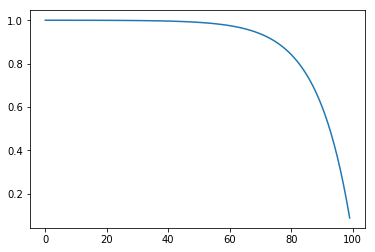

In [10]:
hyp = {'giou': 1.582,  # giou loss gain
       'xy': 4.688,  # xy loss gain
       'wh': 0.1857,  # wh loss gain
       'cls': 27.76,  # cls loss gain
       'cls_pw': 1.446,  # cls BCELoss positive_weight
       'obj': 21.35,  # obj loss gain
       'obj_pw': 3.941,  # obj BCELoss positive_weight
       'iou_t': 0.2635,  # iou training threshold
       'lr0': 0.002324,  # initial learning rate
       'lrf': -4.,  # final LambdaLR learning rate = lr0 * (10 ** lrf)
       'momentum': 0.97,  # SGD momentum
       'weight_decay': 0.0004569,  # optimizer weight decay
       'hsv_s': 0.5703,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.3174,  # image HSV-Value augmentation (fraction)
       'degrees': 1.113,  # image rotation (+/- deg)
       'translate': 0.06797,  # image translation (+/- fraction)
       'scale': 0.1059,  # image scale (+/- gain)
       'shear': 0.5768}  # image shear (+/- deg)


lf = lambda x: 1 - 10 ** (hyp['lrf'] * (1 - x / configs['n_epochs']))  # inverse exp ramp 
lrs_observed = [lf(e) for e in range(configs['n_epochs'])]
plt.plot(lrs_observed)

In [11]:
#training 

from torchsummary import summary
net = yolov2()
device = 'cuda'
net = net.to(device)
# print(summary(net, (3, 416, 416)))

net = torch.nn.DataParallel(net)
loss = yolov2loss(lambda_coord=hyp['xy'], lambda_dims=hyp['wh'], 
                  lambda_noobj=0.5, device=device, lambda_obj=hyp['obj'])

epoch = 0
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer = torch.optim.SGD(net.parameters(), lr=hyp['lr0'], momentum=hyp['momentum'])
lambda_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf) 

# net, optimizer, epoch = resume_train(net, 'chkpt_files/yolov2_model_sgd_100.pth', optimizer)


traindata = CocoDataset(configs['train_batch'], configs['val_batch'])
train_loss, val_loss= [], []
for i in range(epoch, epoch + configs['n_epochs'], 1):
    trainiter = iter(traindata)
    net.train()
    for _ in tqdm(range(len(trainiter)), ncols=100):
        x, y = trainiter.next()
        x = x.to(device)
        y_hat = net(x)
#         loss_value = loss(y_hat, y)
        loss_ = loss(y_hat, y)
#         for p in net.parameters():
#             loss_ += 0.01 * torch.sum(p**2)
        train_loss.append(loss_.item())
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
    lambda_lr.step()

    print('training loss after {}/{} epochs is {} at lr={}'.format(
        i + 1, epoch + configs['n_epochs'], np.mean(train_loss[-len(trainiter):]), 
        optimizer.state_dict()['param_groups'][0]['lr']))

#     if i % configs['val_frequency'] == 0:
#         valiter = iter(valdata)
#         net.eval()
#         with torch.no_grad():
#             for _ in tqdm(range(len(valiter)), ncols=100):
#                 x, y = valiter.next()
#                 x, y = x.to(device), y.to(device)
#                 y_hat = net(x)
#                 loss_ = loss(y_hat, y)
#                 for p in net.parameters():
#                     loss_ += 0.01 * torch.sum(p**2)
#                 val_loss.append(loss_.item())

#             print('validation loss after {}/{} epochs is {}'.format(
#                 i + 1, epoch + configs['n_epochs'], np.mean(val_loss[-len(valiter):])))


loading annotations into memory...


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

Done (t=0.51s)
creating index...
index created!


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 1/100 epochs is 1.513215172290802 at lr=0.0023237451784672166


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 2/100 epochs is 1.1439715832471848 at lr=0.002323720593745395


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 3/100 epochs is 1.0554160103201866 at lr=0.0023236936371339597


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 4/100 epochs is 1.0156981825828553 at lr=0.0023236640797972786


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 5/100 epochs is 0.9725611269474029 at lr=0.002323631670822072


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 6/100 epochs is 0.9653460726141929 at lr=0.0023235961350873986


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 7/100 epochs is 0.9679789155721664 at lr=0.0023235571709291454


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 8/100 epochs is 0.9482415974140167 at lr=0.0023235144475791895


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 9/100 epochs is 0.9315994694828987 at lr=0.002323467602357497


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 10/100 epochs is 0.9218658611178399 at lr=0.002323416237593317


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 11/100 epochs is 0.9302653566002845 at lr=0.0023233599172493443


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 12/100 epochs is 0.9293118476867676 at lr=0.002323298163220179


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 13/100 epochs is 0.9231194853782654 at lr=0.0023232304512736746


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 14/100 epochs is 0.9098866969347 at lr=0.0023231562066007142


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 15/100 epochs is 0.9171824738383293 at lr=0.002323074798935634


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 16/100 epochs is 0.8834227755665779 at lr=0.002322985537205874


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 17/100 epochs is 0.9092514798045158 at lr=0.0023228876636654425


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 18/100 epochs is 0.9134987086057663 at lr=0.0023227803474623796


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 19/100 epochs is 0.9001998156309128 at lr=0.0023226626775856287


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 20/100 epochs is 0.8697052463889122 at lr=0.002322533655131428


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 21/100 epochs is 0.8976714730262756 at lr=0.0023223921848235843


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 22/100 epochs is 0.8834457263350487 at lr=0.002322237065715632


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 23/100 epochs is 0.8846300065517425 at lr=0.0023220669809959574


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 24/100 epochs is 0.8679957568645478 at lr=0.002321880486809337


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 25/100 epochs is 0.8536190569400788 at lr=0.002321676


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 26/100 epochs is 0.8531178027391434 at lr=0.002321451784672163


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 27/100 epochs is 0.8627293795347214 at lr=0.0023212059374539493


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 28/100 epochs is 0.862818717956543 at lr=0.002320936371339595


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 29/100 epochs is 0.8700810343027114 at lr=0.0023206407979727865


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 30/100 epochs is 0.831051480770111 at lr=0.0023203167082207206


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 31/100 epochs is 0.8704692527651787 at lr=0.0023199613508739863


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 32/100 epochs is 0.8485305488109589 at lr=0.0023195717092914536


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 33/100 epochs is 0.8284206092357635 at lr=0.0023191444757918954


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 34/100 epochs is 0.8008219346404075 at lr=0.002318676023574968


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 35/100 epochs is 0.8283564984798432 at lr=0.0023181623759331717


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 36/100 epochs is 0.838528522849083 at lr=0.0023175991724934423


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 37/100 epochs is 0.8207573041319847 at lr=0.002316981632201786


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 38/100 epochs is 0.818085353076458 at lr=0.002316304512736745


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 39/100 epochs is 0.8152096480131149 at lr=0.002315562066007143


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 40/100 epochs is 0.8220030575990677 at lr=0.0023147479893563367


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 41/100 epochs is 0.8026786431670189 at lr=0.0023138553720587385


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 42/100 epochs is 0.7786847680807114 at lr=0.002312876636654422


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 43/100 epochs is 0.7967049792408943 at lr=0.0023118034746237954


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 44/100 epochs is 0.7735283613204956 at lr=0.0023106267758562847


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 45/100 epochs is 0.785139936208725 at lr=0.00230933655131428


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 46/100 epochs is 0.7614416092634201 at lr=0.002307921848235844


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 47/100 epochs is 0.8052686765789986 at lr=0.002306370657156322


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 48/100 epochs is 0.827925169467926 at lr=0.0023046698099595743


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 49/100 epochs is 0.7595351815223694 at lr=0.0023028048680933688


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 50/100 epochs is 0.7787488117814064 at lr=0.0023007600000000002


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 51/100 epochs is 0.7856774598360061 at lr=0.0022985178467216324


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 52/100 epochs is 0.7816339626908302 at lr=0.0022960593745394915


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 53/100 epochs is 0.776631873846054 at lr=0.002293363713395949


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 54/100 epochs is 0.7612093195319176 at lr=0.0022904079797278648


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 55/100 epochs is 0.7457401409745217 at lr=0.002287167082207204


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 56/100 epochs is 0.7543286219239235 at lr=0.0022836135087398643


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 57/100 epochs is 0.700761903077364 at lr=0.0022797170929145343


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 58/100 epochs is 0.7609354466199875 at lr=0.002275444757918952


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 59/100 epochs is 0.7969917342066765 at lr=0.0022707602357496773


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 60/100 epochs is 0.7365586385130882 at lr=0.0022656237593317173


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 61/100 epochs is 0.7514663346111774 at lr=0.002259991724934421


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 62/100 epochs is 0.7419497601687908 at lr=0.0022538163220178573


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 63/100 epochs is 0.6667058549821376 at lr=0.002247045127367446


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 64/100 epochs is 0.7324428133666515 at lr=0.0022396206600714284


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 65/100 epochs is 0.7129352629184723 at lr=0.002231479893563367


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 66/100 epochs is 0.6974048554897309 at lr=0.0022225537205873853


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 67/100 epochs is 0.709071722626686 at lr=0.002212766366544219


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 68/100 epochs is 0.6478483349084854 at lr=0.002202034746237953


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 69/100 epochs is 0.6561230920255184 at lr=0.002190267758562845


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 70/100 epochs is 0.6680896051228047 at lr=0.002177365513142803


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 71/100 epochs is 0.6507096879184247 at lr=0.0021632184823584394


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 72/100 epochs is 0.7108899474143981 at lr=0.002147706571563218


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 73/100 epochs is 0.7211072944104672 at lr=0.0021306980995957395


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 74/100 epochs is 0.7290683075785637 at lr=0.0021120486809336867


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 75/100 epochs is 0.6802108317613602 at lr=0.0020916000000000003


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 76/100 epochs is 0.7360035836696625 at lr=0.002069178467216324


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 77/100 epochs is 0.6558330081403255 at lr=0.0020445937453949133


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 78/100 epochs is 0.7273205772042275 at lr=0.002017637133959491


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 79/100 epochs is 0.7207266226410866 at lr=0.0019880797972786465


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 80/100 epochs is 0.6785214625298976 at lr=0.0019556708220720372


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 81/100 epochs is 0.6701431266963482 at lr=0.001920135087398645


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 82/100 epochs is 0.6524780660867691 at lr=0.0018811709291453415


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 83/100 epochs is 0.6980745978653431 at lr=0.0018384475791895214


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 84/100 epochs is 0.5886504456400872 at lr=0.0017916023574967698


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 85/100 epochs is 0.673207825422287 at lr=0.0017402375933171738


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 86/100 epochs is 0.6460877195000648 at lr=0.0016839172493442103


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 87/100 epochs is 0.6435139194130898 at lr=0.0016221632201785714


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 88/100 epochs is 0.6862263061106205 at lr=0.0015544512736744582


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 89/100 epochs is 0.6265316210687161 at lr=0.0014802066007142845


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 90/100 epochs is 0.6291983611881733 at lr=0.0013987989356336722


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 91/100 epochs is 0.6677568405866623 at lr=0.0013095372058738541


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 92/100 epochs is 0.6130737699568272 at lr=0.001211663665442188


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 93/100 epochs is 0.593035127967596 at lr=0.001104347462379528


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 94/100 epochs is 0.6333826340734958 at lr=0.0009866775856284481


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 95/100 epochs is 0.6186990462243557 at lr=0.0008576551314280315


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 96/100 epochs is 0.5915253102779389 at lr=0.000716184823584392


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 97/100 epochs is 0.6037210896611214 at lr=0.0005610657156321775


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 98/100 epochs is 0.6170784197747707 at lr=0.000390980995957393


  0%|                                                                        | 0/40 [00:00<?, ?it/s]

training loss after 99/100 epochs is 0.6176993869245052 at lr=0.00020448680933686598


100%|███████████████████████████████████████████████████████████████| 40/40 [01:57<00:00,  2.25s/it]

training loss after 100/100 epochs is 0.5830536857247353 at lr=0.0


In [12]:
lambda_lr.last_epoch

100

In [13]:
def save_model(net, optimizer, i, path):
    #saving model to checkpoint 
    torch.save({
            'epoch': i + 1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, path)
save_model(net, optimizer, i, 'chkpt_files/yolov2_model_sgd_100.pth')

In [14]:
#overfit 5 examples 
traindata  = CocoDataset(32, 32)
trainiter = iter(traindata)
x , y = trainiter.next()

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


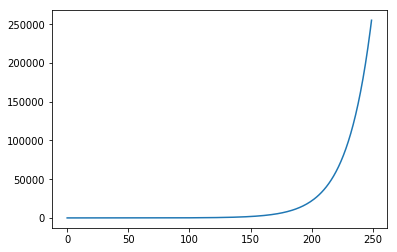

In [15]:
nepochs = 250
lrlambda = lambda x:np.exp(x*0.05)
lrs_observed = [lrlambda(e) for e in range(nepochs)]
plt.plot(lrs_observed)

In [15]:
#nn sanity check
samplex = x[ : 32]
sampley = y[ : 32]

device = 'cuda:0'
net = yolov2()
net = net.to(device)
net.train()
# net = torch.nn.DataParallel(net)
loss = yolov2loss(lambda_coord=1, lambda_noobj=1, device=device)
loss_plot = []
# optimizer = torch.optim.Adam(net.parameters(), lr=0.5e-4)
optimizer = torch.optim.SGD(net.parameters(), lr=0.5e-4, momentum=0.9, weight_decay=0.005)
# lambda_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lrlambda)
lambda_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf) 

for i in range(nepochs):
    samplex = samplex.to(device)
    sampley_hat = net(samplex)
#         loss_value = loss(y_hat, y)
    loss_ = loss(sampley_hat, sampley)
    loss_plot.append(loss_.item())
#         for p in net.parameters():
#             loss_ += 0.01 * torch.sum(p**2)
    optimizer.zero_grad()
    loss_.backward()
    optimizer.step()
    lambda_lr.step()

#     print('training loss after {}/{} epochs is {}'.format(
#         i + 1, 300, loss_.item()))
plt.plot(loss_plot)

KeyboardInterrupt: 

4.996245587351462e-05

In [40]:

np.random.seed(100)
color_dict = np.random.rand(num_classes,3)


def visualize_bbox(image, label_tensor, save_path=None, resolution=13):
    fig, ax = plt.subplots(1)
    if isinstance(image, torch.Tensor):
        ax.imshow(image.permute(1,2,0))
        scale_x, scale_y = image.size(1), image.size(2)
    else:
        ax.imshow(image)
        scale_x, scale_y = image.shape[0], image.shape[1]

    if len(list(label_tensor.shape)) <  2:
        if save_path is not None :
            plt.savefig(save_path) 
            return 
        if torch.max(label_tensor) > 1:
            label_tensor[:, :2] /= torch.tensor([scale_x, scale_y], dtype=torch.float32)
            label_tensor[:, 2:4] /= torch.tensor([scale_x, scale_y], dtype=torch.float32)

    if len(list(label_tensor.shape)) == 3:
        print ('recieved true labels')
        x = torch.tensor(torch.arange(resolution))
        y = torch.tensor(torch.arange(resolution))
        grid_x, grid_y = torch.meshgrid(x, y)
        grid = torch.cat([grid_y.unsqueeze(0), grid_x.unsqueeze(0)], 0).type(torch.float)
        #print (grid)
        label_tensor[:2,:,:] += grid 
        label_tensor[:2,:,:] /= 7
        label_tensor = label_tensor.permute(1, 2, 0)
        object_mask = label_tensor[:, :, 4] == 1
        object_mask = object_mask.unsqueeze(dim=-1).expand(label_tensor.shape)
        #arrange the values into a tensor of box coordinates 
        label_tensor = label_tensor[object_mask].view((-1, 6))

    centers = label_tensor[:,:2]
    sizes = label_tensor[:,2:4]
    label_tensor[:,:2] = centers - sizes / 2
    label_tensor[:,:2] = label_tensor[:,:2] * torch.tensor([scale_x, scale_y], dtype=torch.float32)
    label_tensor[:,2:4] = label_tensor[:,2:4] * torch.tensor([scale_x, scale_y], dtype=torch.float32)
    confs = label_tensor[:, 4].numpy()
    label_tensor = label_tensor.to(torch.int16)
    for i in range(label_tensor.size(0)):
        ax.add_patch(patches.Rectangle((label_tensor[i, 0], label_tensor[i, 1]),
                                                        label_tensor[i, 2], label_tensor[i, 3], 
                                                        color=color_dict[label_tensor[i, 5]], fill=False))
        ax.text(label_tensor[i, 0], label_tensor[i, 1], 
                class_names['coconames'][label_tensor[i, 5].item()]['display_name'] + \
                ': ' + str(round(confs[i], 2)),
                fontsize=20, color=color_dict[label_tensor[i, 5]])
    if save_path is not None:
        plt.savefig(save_path)
    else :
        fig.canvas.draw()
        return np.array(fig.canvas.renderer.buffer_rgba()) 

In [41]:
#once we get predictions we need to do nms for selecting good predictions
def boxes_IoU(bb1, bb2):
    '''
    bb1 : input bounding box 1 the coordinates corresponds to 
          center_x center_y width height
    bb2 : bounding box 2 coordinates in the same order as bb1
    '''
    minx = max(bb1[0] - bb1[2] / 2, bb2[0] - bb2[2] / 2)
    maxx = min(bb1[0] + bb1[2] / 2, bb2[0] + bb2[2] / 2)
    miny = max(bb1[1] - bb1[3] / 2, bb2[1] - bb2[3] / 2)
    maxy = min(bb1[1] + bb1[3] / 2, bb2[1] + bb2[3] / 2)
    diffx = (maxx - minx) #- (bb1[2] + bb2[2]) 
    diffy = (maxy - miny) #- (bb1[3] + bb2[3])
    if diffx > 0  and diffy >  0 :
        intersection = diffx * diffy
        return intersection / (bb1[2] * bb1[3] + bb2[2] * bb2[3] - intersection) 
    return 0


def non_max_suppression(predicted_tensor, iou_threshold=0.6, obj_threshold=0.25, resolution=13):
    #grid coordinates to add to predicted offset
    predicted_tensor = predicted_tensor.cpu()
    x = torch.tensor(torch.arange(resolution))
    y = torch.tensor(torch.arange(resolution))
    grid_x, grid_y = torch.meshgrid(x, y)
    grid = torch.cat([grid_y.unsqueeze(-1), grid_x.unsqueeze(-1)], 2).type(torch.float)
    
    predictions = predicted_tensor.view(predicted_tensor.shape[0], num_anchors, num_classes + 5, 
                                        resolution, resolution).permute(0,1,3,4,2)
    
    for i in range(num_anchors):
        predictions[:, i, :, :, :2] = (torch.sigmoid(predictions[:, i, :, :, :2]) + grid ) /resolution
        predictions[:, i, :, :, 2:4] = torch.exp(predictions[:, i, :, :, 2:4])*anchors[i]
        predictions[:, i, :, :, 4] = torch.sigmoid(predictions[:, i, :, :, 4])
    

    predictions = predictions.contiguous().view(predictions.shape[0], -1, predictions.shape[-1])
    predlabels = torch.argmax(predictions[:, :, 5:], 2, keepdim=True).to(torch.float)

    #here we pass all boxes as a 2d array 
#     boxes = torch.cat([box1, box2], 1).numpy()
    boxes = torch.cat([predictions[:, :, :5], predlabels], 2)

    obj_mask = boxes[:, :, 4] >= obj_threshold
    selected_boxes = []

    for box, mask in zip(boxes, obj_mask):
        mask = mask.reshape(-1)
        this_boxes = []
        temp_boxes = []
        for i in range(mask.shape[0]):
            if mask[i]:
                temp_boxes.append(box[i])

        box = sorted(temp_boxes, key=lambda a:a[-2])
        box = box[::-1]
 
        box_list = [[] for _ in range(num_classes)]
        for i in range(len(box)):
            box_list[int(box[i][-1])].append(box[i]) 
        for sorted_ in box_list:
            while len(sorted_) > 0:
                this_box = sorted_[0]
                del sorted_[0]
                sorted_new = []
                for i in range(len(sorted_)):
                    if boxes_IoU(this_box, sorted_[i]) < iou_threshold:
                        sorted_new.append(sorted_[i])
                
                sorted_ = sorted_new
                this_boxes.append(this_box.to(torch.float).unsqueeze(0))
        
        selected_boxes.append(torch.cat(this_boxes, 0))
    return selected_boxes

In [42]:
x = x.to(device)
with torch.no_grad():
    predictions = net(x)

In [43]:
predictions.shape

torch.Size([32, 425, 13, 13])

In [55]:
nms = non_max_suppression(predictions[0].unsqueeze(0), obj_threshold=0.867)

/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dgxuser/namuchan/torch101_venv/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [56]:
nms[0].shape

torch.Size([1, 6])

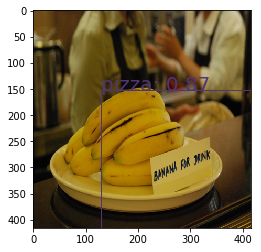

In [57]:
save_path = 'results/train_preds_e{}.png'.format(i + 1)
visualize_bbox(x[0].to('cpu'), nms[0], save_path)

In [36]:
y[1]

tensor([[6.5272e-01, 3.1077e-01, 9.6028e-01, 8.7192e-01, 8.6000e+01],
        [1.7459e-01, 3.2944e-01, 5.2378e-01, 9.4502e-01, 8.6000e+01],
        [4.4625e-02, 1.0389e-01, 2.8517e-01, 8.5713e-01, 8.6000e+01],
        [3.8992e-01, 1.0130e-01, 6.4987e-01, 8.4676e-01, 8.6000e+01]])

In [37]:
y_temp = torch.tensor([[6.5272e-01, 3.1077e-01, 9.6028e-01, 8.7192e-01, 1, 8.6000e+01],
        [1.7459e-01, 3.2944e-01, 5.2378e-01, 9.4502e-01, 1, 8.6000e+01],
        [4.4625e-02, 1.0389e-01, 2.8517e-01, 8.5713e-01, 1, 8.6000e+01],
        [3.8992e-01, 1.0130e-01, 6.4987e-01, 8.4676e-01, 1, 8.6000e+01]])

y_temp[:, :2] = (y_temp[:, :2] + y_temp[:, 2:4])/2
y_temp[:, 2:4] = (y_temp[:, 2:4] - y_temp[:, :2])*2

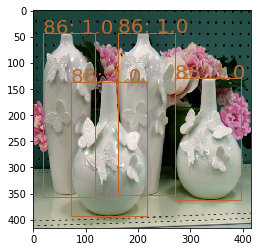

In [38]:
save_path = 'results/train_preds_e{}.png'.format(i + 1)
visualize_bbox(x[1].to('cpu'), y_temp, save_path)

In [111]:
len(class_labels)

80